In [8]:
%load_ext pretty_jupyter

In [9]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns',None)
warnings.simplefilter(action='ignore')

In [10]:
def mostrar_adesao(df, columns):
    for col in columns:
        response_pct = df.groupby(col)['Response'].mean().reset_index()
        response_pct['Response'] = (response_pct['Response'] * 100).round(2)
        response_pct = response_pct.rename(columns={'Response': 'Adesão'})

        sample_size = df.groupby(col)['Response'].count().reset_index()
        sample_size = sample_size.rename(columns={'Response': 'Amostra'})

        display(pd.merge(response_pct, sample_size, on=col))

def z_test_category(df, column,target='Response'):
    converted = df[df[target] == 1][column].value_counts().sort_index()
    total = df[column].value_counts().sort_index()

    z, p = proportions_ztest(count=converted, nobs=total)

    if p < 0.05:
        print('Significativamente diferente')
    else:
        print('Sem diferença estatística')

    print(f'p: {p}')
    print(f'Z: {z}')

def analisar_distribuicao_categorica(df, colunas_categoricas, target='Response'):
    for coluna in colunas_categoricas:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df, x=coluna, hue=target)
        plt.title(coluna)
        plt.ylabel('Contagem')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

def response_countplot(df, category_col, title=None, target='Response', category_order=None, figsize=(8, 5)):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=category_col, hue=target, order=category_order)
    plt.title(title if title else category_col)
    plt.xlabel(category_col)
    plt.ylabel('Contagem')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

def response_rateplot(df, category_col, title=None, target='Response', category_order=None, figsize=(8, 5)):
    response_rate = df.groupby(category_col)[target].mean().reset_index()
    response_rate[target] = (response_rate[target] * 100).round(2)

    if category_order:
        response_rate[category_col] = pd.Categorical(
            response_rate[category_col],
            categories=category_order,
            ordered=True
        )
        response_rate = response_rate.sort_values(category_col)

    plt.figure(figsize=figsize)
    sns.lineplot(data=response_rate, x=category_col, y=target, marker='o', color='black')
    plt.title(title if title else category_col)
    plt.xlabel(category_col)
    plt.ylabel('% de Resposta (Adesão)')
    plt.ylim(bottom=0)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

def analisar_distribuicao_numerica(df, coluna, title=None, target='Response'):
    colors = {0: '#1f77b4', 1: '#ff7f0e'}
    valores_unicos = sorted(df[target].dropna().unique())

    fig, (box_plot, hist_plot) = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={'height_ratios': [1, 3]})

    labels = [str(val) for val in valores_unicos]

    box_plot.boxplot(
        [df[df[target] == val][coluna].dropna() for val in valores_unicos],
        vert=False,
        showmeans=True,
        labels=labels,
        patch_artist=True,
        boxprops=dict(facecolor='#e0e0e0')
    )
    box_plot.set_title(title if title else coluna)
    box_plot.set_ylabel(target)

    for val in valores_unicos:
        hist_plot.hist(
            df[df[target] == val][coluna].dropna(),
            bins='auto',
            alpha=0.6,
            label=str(val),
            color=colors.get(val, None)
        )

    hist_plot.legend(title=target)
    hist_plot.set_xlabel(coluna)
    hist_plot.set_ylabel('Frequência')
    hist_plot.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

In [11]:
df = pd.read_csv('ml_project1_data.csv')

In [12]:
df.columns = df.columns.str.replace('_','').str.replace('Prods','Products')
df = df.rename(columns={'Kidhome':'KidHome','Teenhome':'TeenHome'})

In [13]:
df['DtCustomer'] = pd.to_datetime(df['DtCustomer'], errors='coerce')

In [14]:
df.loc[df['Income'].isna(),'Income'] = df['Income'].median()

In [15]:
dados_categoricos = [
    'Education', 'MaritalStatus', 'KidHome', 'TeenHome', 'AcceptedCmp1',
    'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain'
]
dados_numericos = [
    'YearBirth', 'Income', 'Recency', 'MntWines', 'MntFruits',
    'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProducts', 
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
    'NumWebVisitsMonth'
]

for col in dados_categoricos:
    df[col] = df[col].astype('object')
for col in dados_numericos:
    df[col] = df[col].astype('int64')

In [16]:
df.loc[df['MaritalStatus']=='Alone','MaritalStatus'] = 'Single'

marital_status_outros = ['Absurd','YOLO']
df['MaritalStatus'] = df['MaritalStatus'].apply(lambda x: 'Other' if x in marital_status_outros else x)

In [17]:
education_map = {
    'Basic': 'Low Education',
    'Graduation': 'Medium Education',
    '2n Cycle': 'Medium Education',
    'Master': 'High Education',
    'PhD': 'High Education'
}

df['EducationGroup'] = df['Education'].map(education_map)

high_education = ['Master','PhD']

df['IsHighEducation'] = df['Education'].isin(high_education).astype(int).astype(object)

In [18]:
no_partner_statuses = ['Single', 'Divorced', 'Widow', 'Other']

df['IsAlone'] = df['MaritalStatus'].isin(no_partner_statuses).astype(int).astype(object)

In [19]:
filhos = ['KidHome','TeenHome']

df['ChildrenSum'] = df[filhos].sum(axis=1).astype(object)

df['HaveChildren'] = df[filhos].any(axis=1).astype(int).astype(object)

In [20]:
campanhas_anteriores = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

df['AcceptedCmpSum'] = df[campanhas_anteriores].sum(axis=1).astype(object)

df['IsAcceptedAny'] = df[campanhas_anteriores].any(axis=1).astype(int).astype(object)

In [21]:
df.loc[df['YearBirth']<1940,'YearBirth'] = df['YearBirth'].median()

In [22]:
df.loc[df['Income']==666666,'Income'] = df['Income'].median()

# Resumo

## Problema

Uma campanha piloto foi realizada para testar a receptividade de um novo produto. O custo total da campanha foi de 6.720, enquanto a receita gerada pelos clientes que aderiram foi de 3.674, resultando em um retorno financeiro global negativo de -3.046. A taxa de conversão ficou em torno de 15%. Diante desse cenário, busca-se compreender melhor o perfil dos clientes que aceitaram a oferta, bem como otimizar a abordagem para a próxima campanha.

## Objetivo/Entregáveis  
- **Análise Exploratória:**

    Investigar as principais variáveis e como elas se relacionam com a adesão à oferta.  
- **Segmentação de Usuários:**

    Agrupar clientes em perfis/segmentos para guiar ações mais direcionadas.  
- **Modelo para a Próxima Campanha:**

    Desenvolver um modelo para identificar clientes com maior probabilidade de aderir às ofertas, tendo como base o resultado financeiro.

# Análise Exploratória

[//]: # (-.- .tabset .tabset-pills)

Esta seção tem como objetivo explorar os dados em maior profundidade e compreender a relação entre as variáveis e a adesão dos usuários à campanha.

## Insights
|Variável|Insight|
|---|---|
|Escolaridade| Quanto maior, maior a taxa de adesão.|
|Parceria| Usuários sem parceiro aderem o dobro, mesmo sendo metade da amostra.|
|Estado civil| Isoladamente, tem pouca relevância — o fator chave é ter ou não parceiro.|
|Filhos| Mais filhos, menor adesão. Sem filhos = quase 3x mais chance de aderir.|
|Campanhas anteriores| Já ter aderido aumenta em 4x a chance de nova adesão.|
|Reclamações| Não influenciam o comportamento de adesão.|
|Renda| Quanto maior, maior a chance de adesão.|
|Abandono| Menor abandono, maior probabilidade de aderir.|
|Gastos| Usuários que gastam mais aderem mais.|
|Compras| Mais compras, maior adesão.|
|Visitas ao site| Quantidade de visitas não afeta a adesão.|

## Gráficos (Adesão vs Principais Variáveis)

### Variáveis Categóricas

#### Escolaridade

[//]: # (-.- .tabset .tabset-pills)

- Há uma progressão clara entre o nível de escolaridade e a taxa de adesão à última campanha: quanto maior a escolaridade, maior a taxa de resposta.
- O grupo com baixa escolaridade (Basic):
    - Menor amostra (54)
    - Menor taxa de adesão (3,7%)
- O grupo com escolaridade média (2nd Cycle, Graduation):
    - Maior amostra (1.330)
    - Adesão intermediária (13%)
- O grupo com escolaridade alta (Master, PhD):
    - Amostra intermediária (856)
    - Maior adesão (18,5%)

##### Escolaridade Agrupada

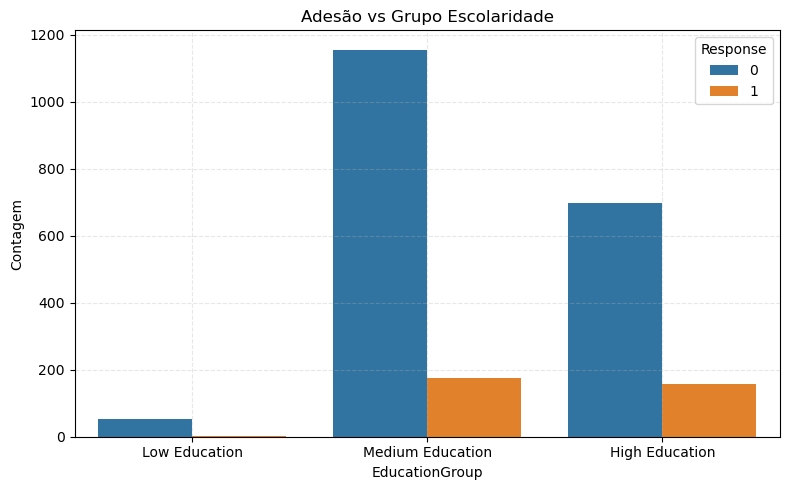

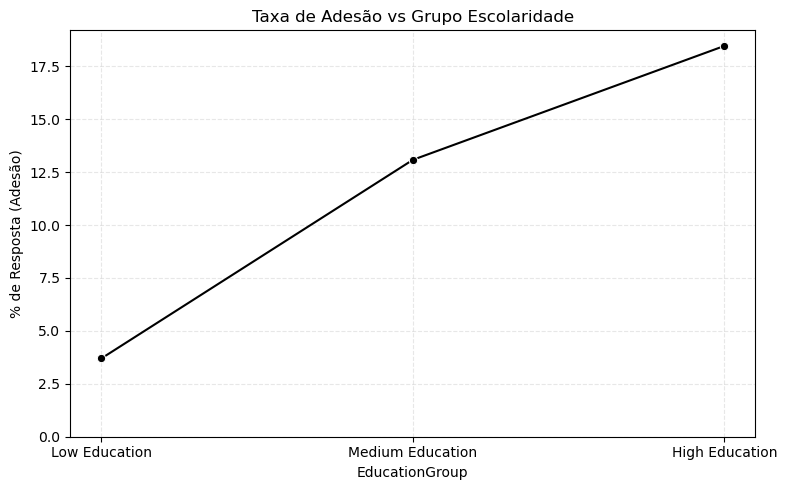

In [23]:
response_countplot(
    df,
    category_col='EducationGroup',
    title='Adesão vs Grupo Escolaridade',
    category_order=['Low Education', 'Medium Education', 'High Education']
)

response_rateplot(
    df,
    category_col='EducationGroup',
    title='Taxa de Adesão vs Grupo Escolaridade',
    category_order=['Low Education', 'Medium Education', 'High Education']
)

##### Escolaridade Detalhada

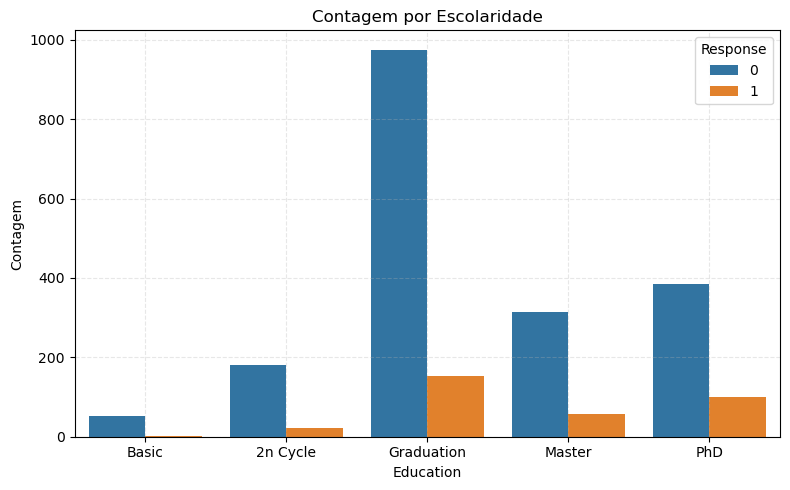

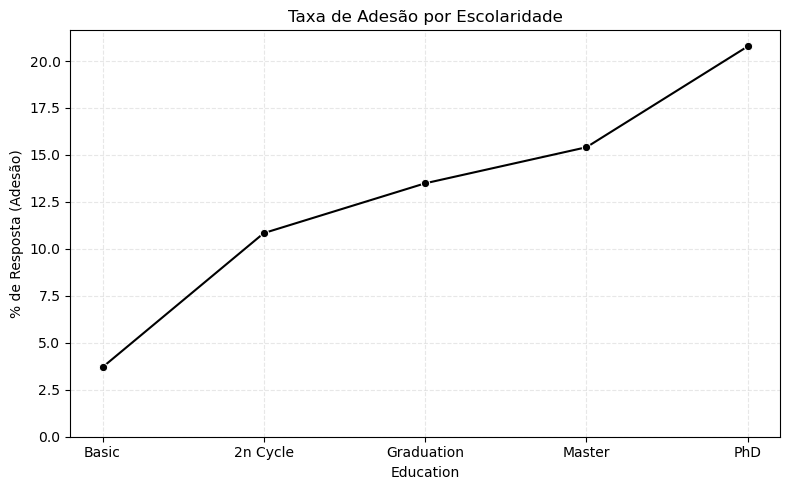

In [24]:
response_countplot(
    df,
    category_col='Education',
    title='Contagem por Escolaridade',
    category_order=['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
)
response_rateplot(
    df,
    category_col='Education',
    title='Taxa de Adesão por Escolaridade',
    category_order=['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
)

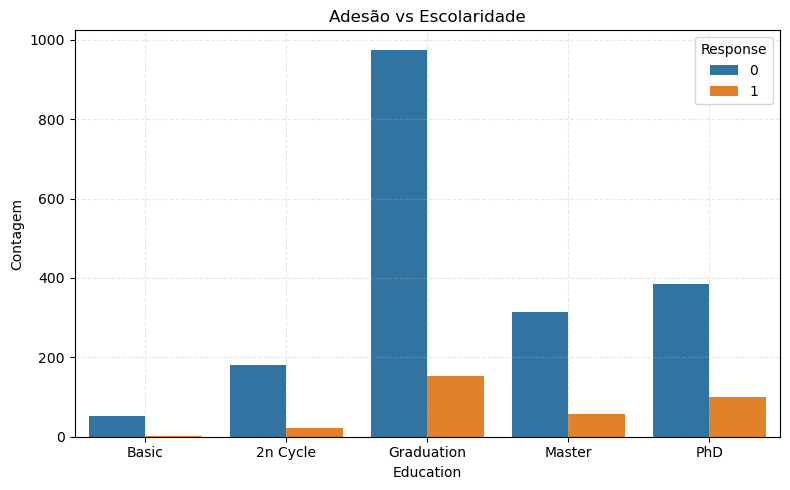

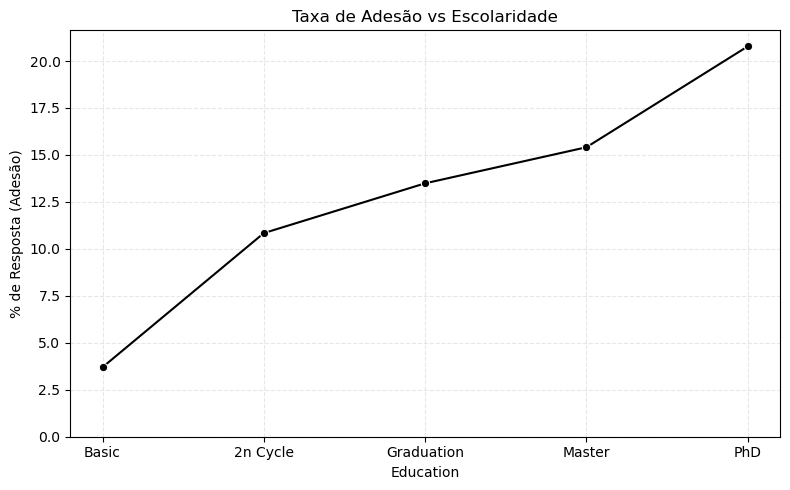

In [25]:
response_countplot(
    df,
    category_col='Education',
    title='Adesão vs Escolaridade',
    category_order=['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
)

response_rateplot(
    df,
    category_col='Education',
    title='Taxa de Adesão vs Escolaridade',
    category_order=['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
)

#### Estado Civil

[//]: # (-.- .tabset .tabset-pills)

- Mais do que o estado civil isolado, o que realmente importa é se o usuário possui um parceiro ou não.
- Usuários sem parceiro apresentam uma taxa de adesão duas vezes maior, mesmo representando apenas metade da amostra.
- Grupo com parceiro (Married, Together):
    - Maior amostra (1.444)
    - Menor adesão (11%)
- Grupo sem parceiro (Single, Divorced, Widow, Other):
    - Menor amostra (796)
    - Maior adesão (22%)

##### Flag de Solitude

0 = Tem parceiro  
1 = Não tem parceiro

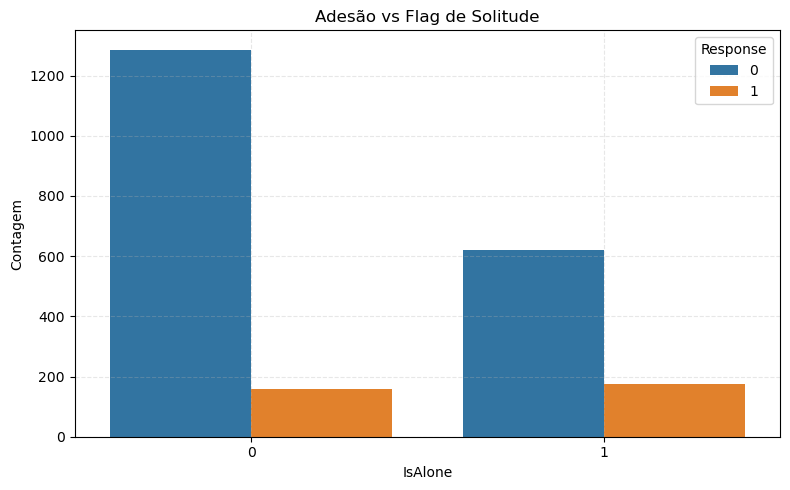

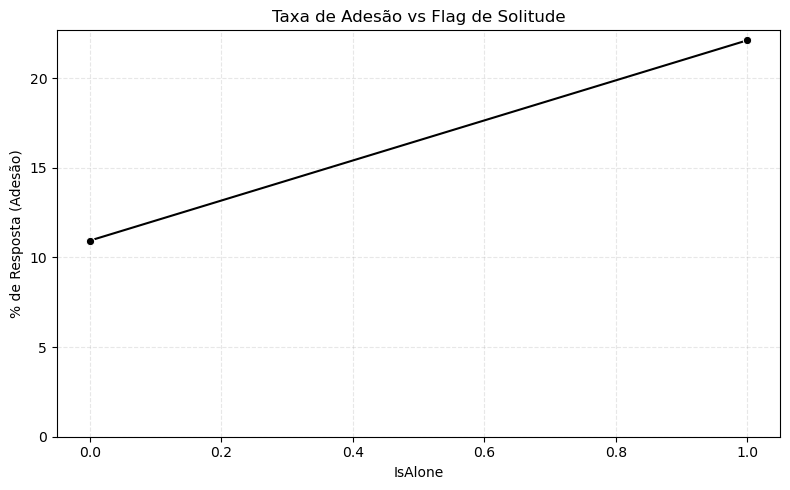

In [26]:
response_countplot(
    df,
    category_col='IsAlone',
    title='Adesão vs Flag de Solitude',
)

response_rateplot(
    df,
    category_col='IsAlone',
    title='Taxa de Adesão vs Flag de Solitude',
)

##### Estado Civil Completo

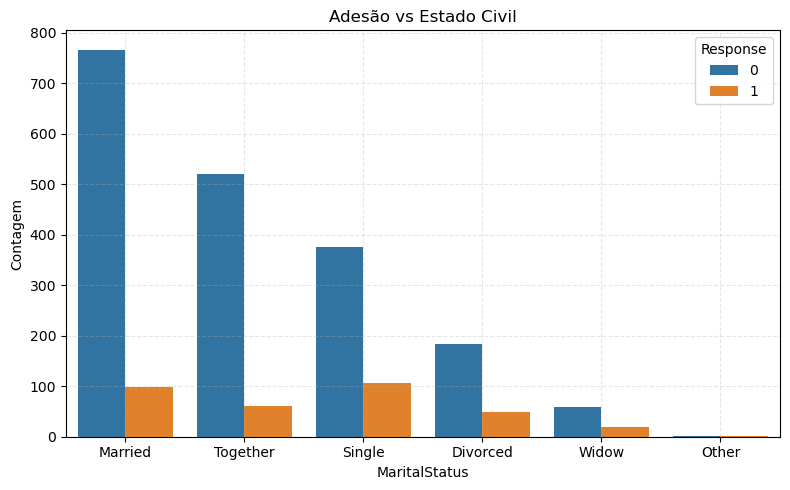

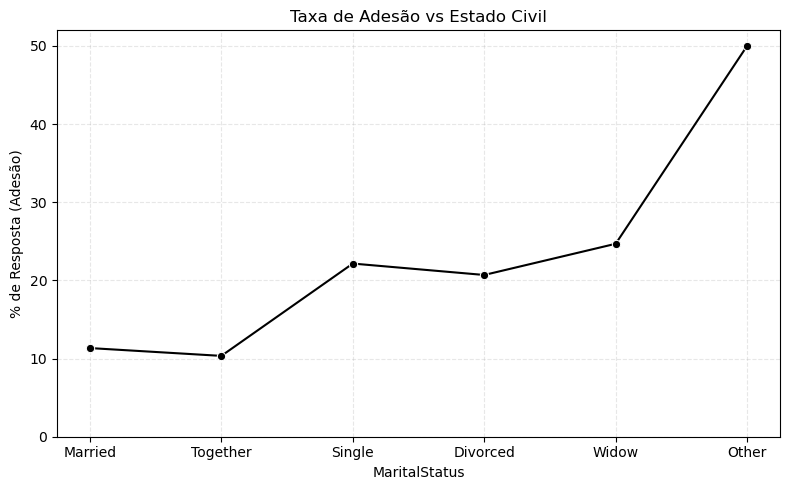

In [27]:
response_countplot(
    df,
    category_col='MaritalStatus',
    title='Adesão vs Estado Civil',
    category_order=['Married', 'Together', 'Single', 'Divorced', 'Widow', 'Other']
)

response_rateplot(
    df,
    category_col='MaritalStatus',
    title='Taxa de Adesão vs Estado Civil',
    category_order=['Married', 'Together', 'Single', 'Divorced', 'Widow', 'Other']
)

#### Filhos

[//]: # (-.- .tabset .tabset-pills)

- Observa-se uma tendência inversa (embora não linear) entre o número de filhos e a taxa de adesão: quanto mais filhos, menor a probabilidade de aderir a uma nova campanha.
- Usuários sem filhos têm quase 3 vezes mais chance de adesão em comparação aos que possuem filhos.
- Grupo com filhos:
    - Maior amostra (1.602)
    - Menor adesão (10,3%)
- Grupo sem filhos:
    - Menor amostra (638)
    - Maior adesão (26,5%)

##### Flag de Filhos

0 = Não tem filhos criança ou adolescente  
1 = Tem filhos criança ou adolescente

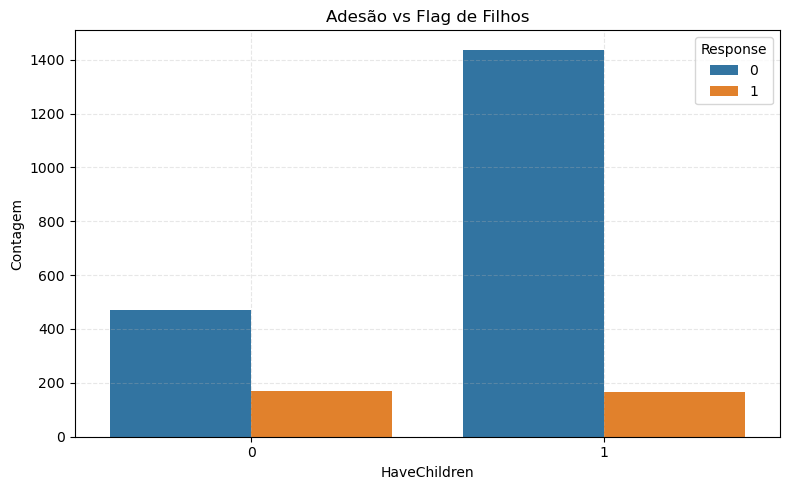

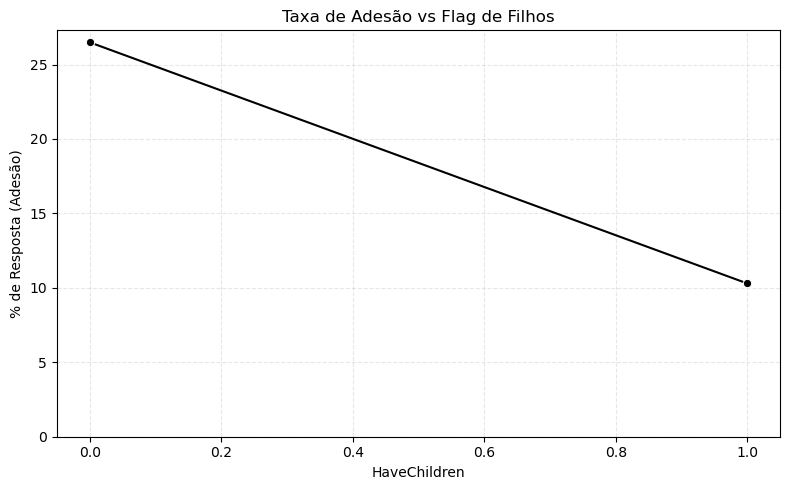

In [ ]:
response_countplot(
    df,
    category_col='HaveChildren',
    title='Adesão vs Flag de Filhos',
)

response_rateplot(
    df,
    category_col='HaveChildren',
    title='Taxa de Adesão vs Flag de Filhos',
)

##### Quantidade de Filhos

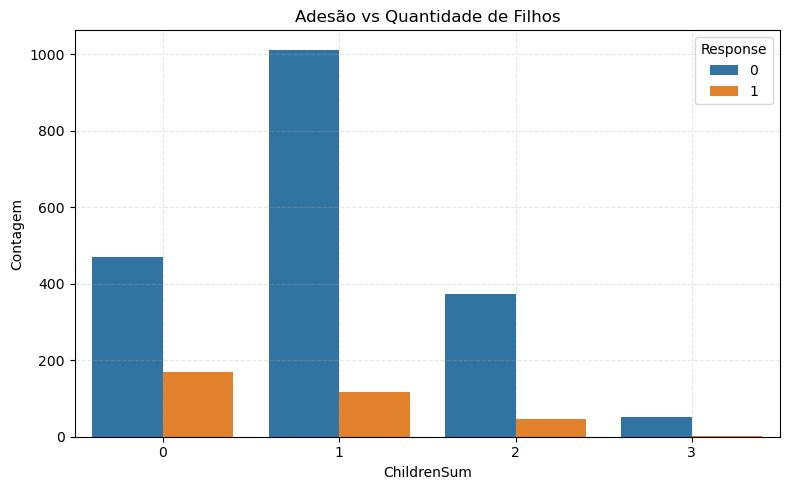

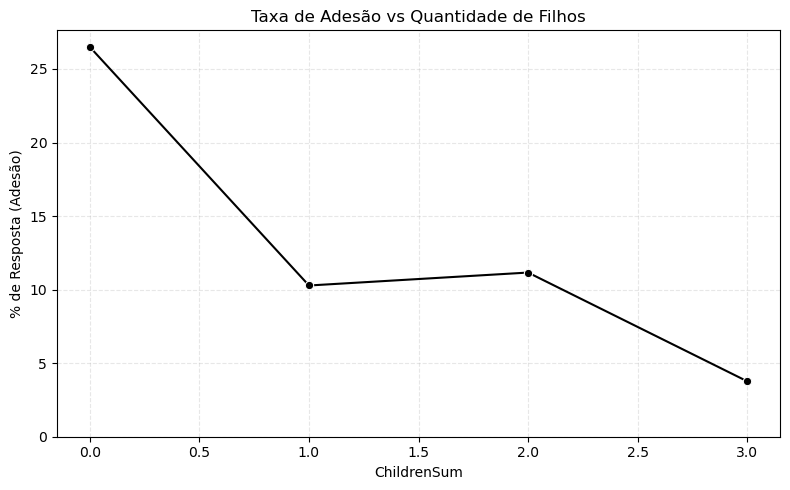

In [28]:
response_countplot(
    df,
    category_col='ChildrenSum',
    title='Adesão vs Quantidade de Filhos',
)

response_rateplot(
    df,
    category_col='ChildrenSum',
    title='Taxa de Adesão vs Quantidade de Filhos',
)

#### Campanhas Anteriores

[//]: # (-.- .tabset .tabset-pills)

- Quanto maior o número de campanhas anteriores aderidas, maior o nível de fidelização do usuário e, consequentemente, sua chance de aderir a uma nova.
- Usuários que já aderiram a pelo menos uma campanha anterior têm quatro vezes mais chance de adesão em comparação aos que nunca aderiram.
- Grupo sem adesão anterior:
    - Maior amostra (1.777)
    - Menor adesão (8,2%)
- Grupo com adesão anterior:
    - Menor amostra (463)
    - Maior adesão (40,6%)

##### Flag Adesão Anterior

0 = Não fez adesão em nenhuma campanha anteriormente  
1 = Fez adesão em alguma campanha anteriormente

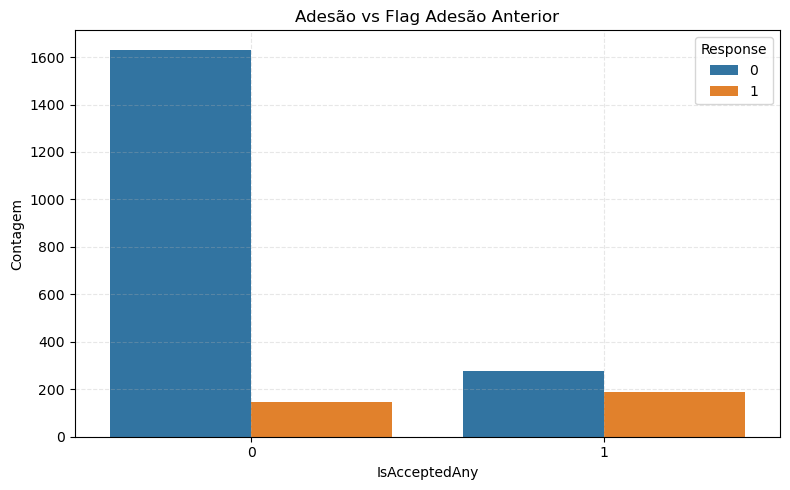

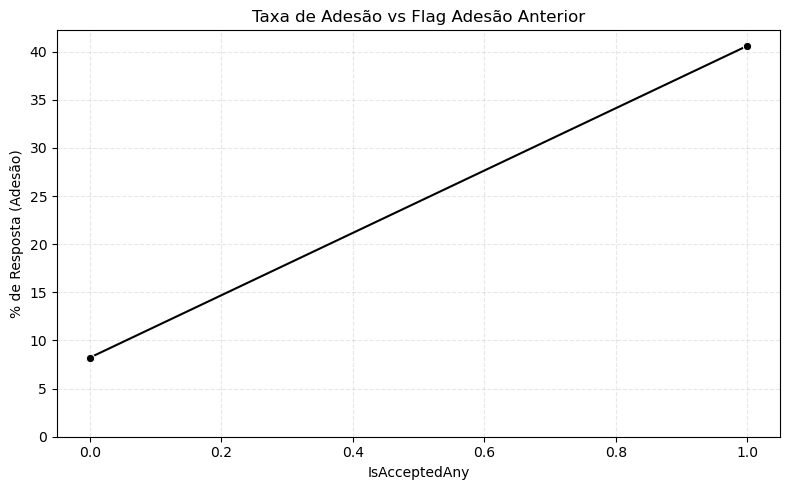

In [30]:
response_countplot(
    df,
    category_col='IsAcceptedAny',
    title='Adesão vs Flag Adesão Anterior',
)

response_rateplot(
    df,
    category_col='IsAcceptedAny',
    title='Taxa de Adesão vs Flag Adesão Anterior',
)

##### Aderência em Campanhas Anteriores

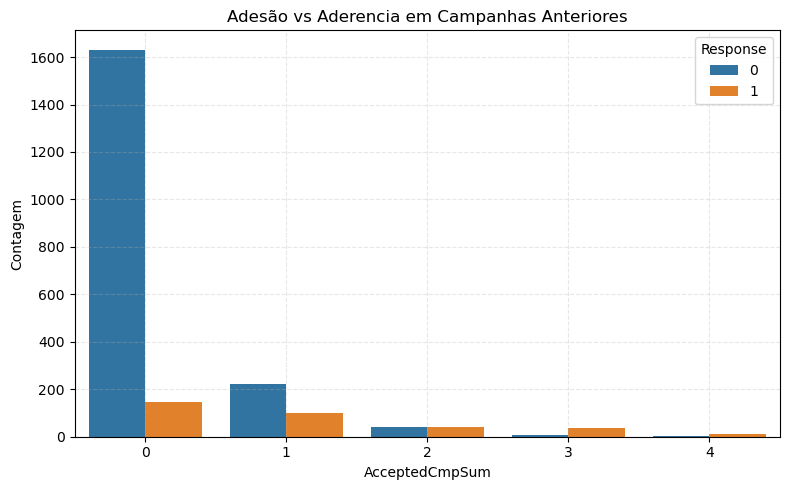

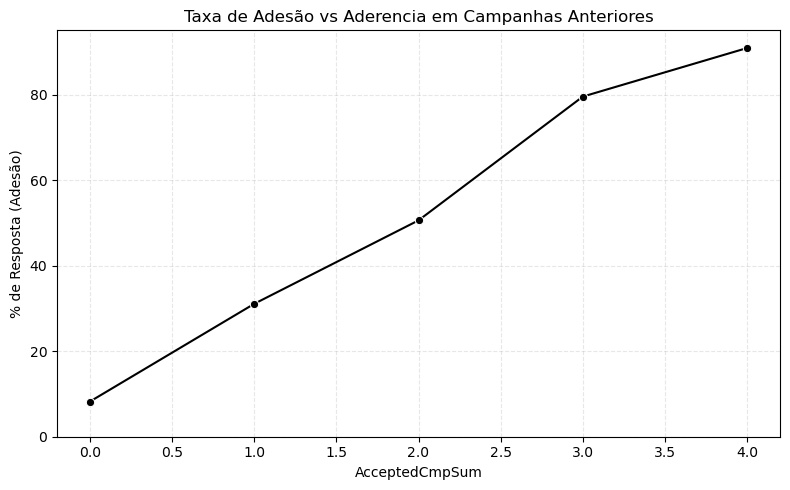

In [31]:
response_countplot(
    df,
    category_col='AcceptedCmpSum',
    title='Adesão vs Aderencia em Campanhas Anteriores',
)

response_rateplot(
    df,
    category_col='AcceptedCmpSum',
    title='Taxa de Adesão vs Aderencia em Campanhas Anteriores',
)

#### Reclamações

- Não há significância estatística: o padrão de adesão entre quem reclamou é semelhante ao de quem não reclamou.

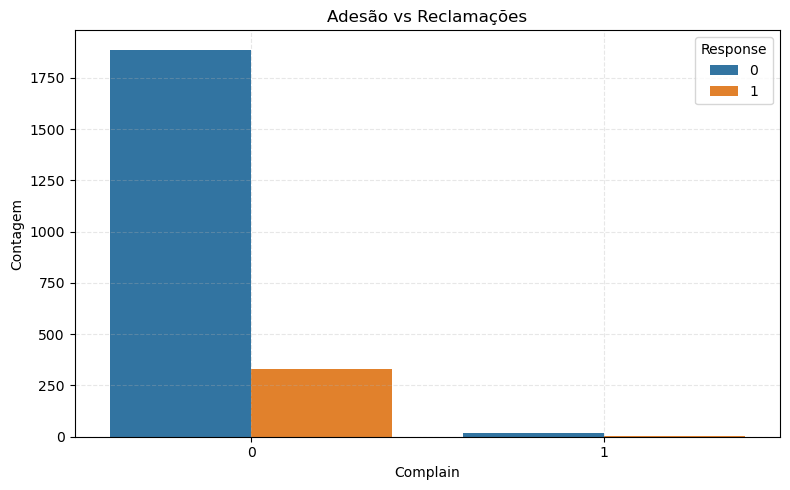

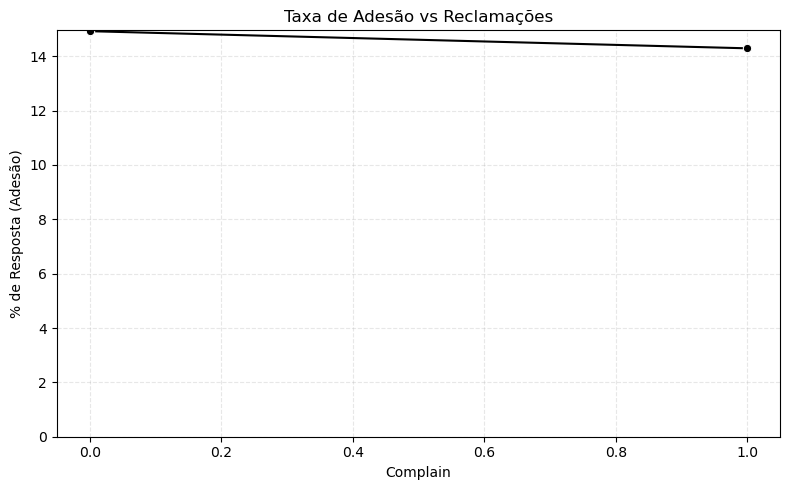

In [32]:
response_countplot(
    df,
    category_col='Complain',
    title='Adesão vs Reclamações',
)

response_rateplot(
    df,
    category_col='Complain',
    title='Taxa de Adesão vs Reclamações',
)

### Variáveis Numéricas

#### Ano de Nascimento

- Não há significância estatística: os públicos com e sem adesão seguem padrões similares.

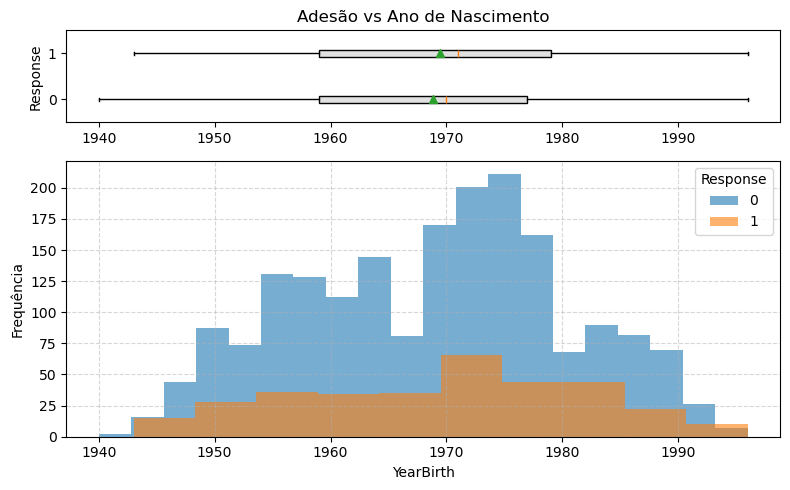

In [33]:
analisar_distribuicao_numerica(df, 'YearBirth', title='Adesão vs Ano de Nascimento')

#### Renda

- O público com maior renda apresenta maior adesão às novas campanhas.  
- A maior concentração de pessoas está na faixa de renda entre 70.000 e 90.000.

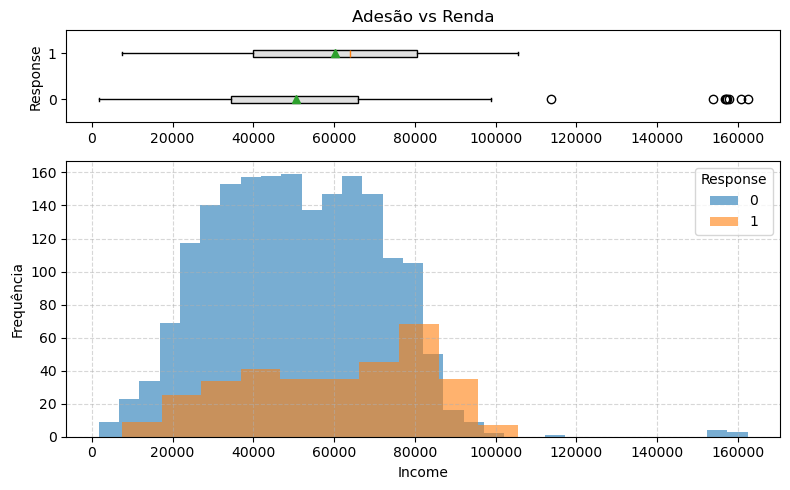

In [34]:
analisar_distribuicao_numerica(df, 'Income', title='Adesão vs Renda')

#### Abandono

- Usuários com menor tempo de abandono têm maior probabilidade de aderir a uma nova campanha.  
- A maior concentração está entre 0 e 20 dias de abandono.

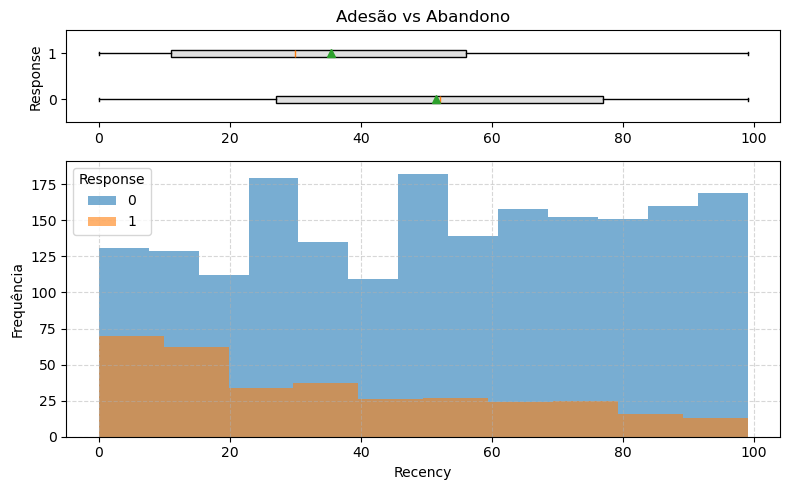

In [35]:
analisar_distribuicao_numerica(df, 'Recency', title='Adesão vs Abandono')

#### Gastos

- Usuários com maior volume de gastos têm maior probabilidade de aderir às campanhas em comparação aos que gastam menos.  
- Embora o público que adere esteja bem distribuído, a diferença em relação aos que não aderem se torna mais evidente a partir de 1.500 em gastos.

In [36]:
gastos = ['MntWines', 'MntFruits','MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProducts']

df['MntSumProducts'] = df[gastos].sum(axis=1).astype(int)

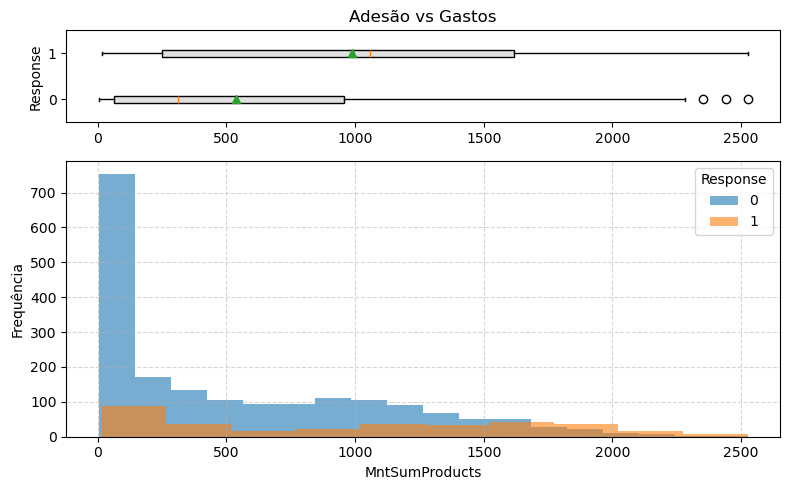

In [37]:
analisar_distribuicao_numerica(df,'MntSumProducts', title='Adesão vs Gastos')

#### Compras

- Usuários com maior número de compras têm uma probabilidade mais alta de aderir às campanhas, em comparação àqueles com menos compras.

In [38]:
compras = ['NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases']

df['MumSumPurchases'] = df[compras].sum(axis=1).astype(int)

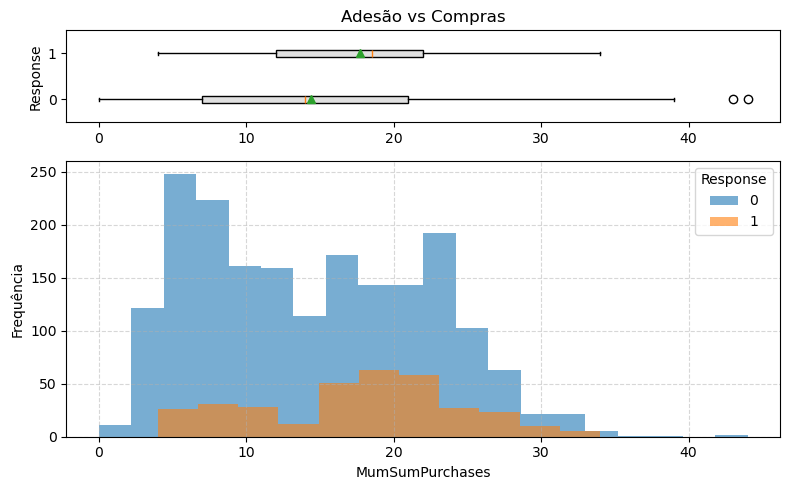

In [39]:
analisar_distribuicao_numerica(df,'MumSumPurchases', title='Adesão vs Compras')

#### Visitas Web

- A probabilidade de adesão às campanhas é semelhante entre usuários com diferentes quantidades de visitas ao site.

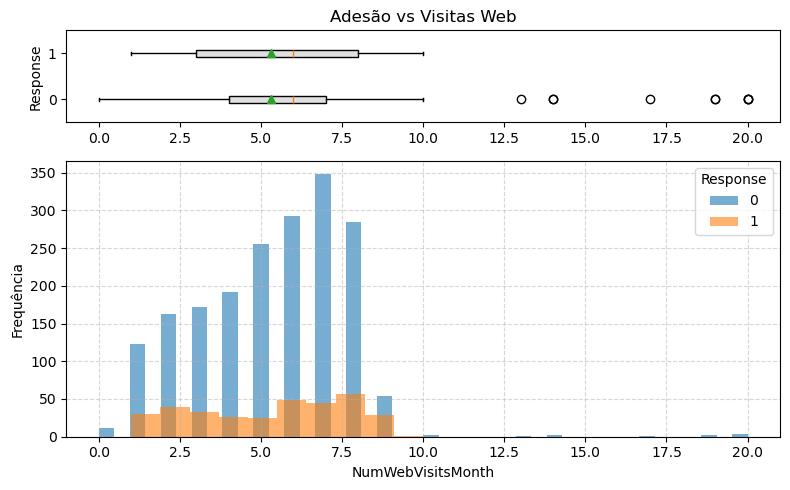

In [40]:
analisar_distribuicao_numerica(df,'NumWebVisitsMonth', title='Adesão vs Visitas Web')

# Segmentação de Usuários

[//]: # (-.- .tabset .tabset-pills)

Esta seção tem como objetivo segmentar o público da campanha piloto, a fim de entender melhor os perfis de usuários que temos.

Para entender melhor os perfis de usuários, aplicamos uma segmentação via K-Means, utilizando variáveis-chave como renda, tempo desde a última compra, total gasto, número de compras, além de flags demográficas e de engajamento. O método do cotovelo indicou 2 clusters ideais.

## Públicos identificados

**Cluster 0 – Engajados / Jovens**  
- 22,4% de adesão a campanhas  
- Menor renda, menos filhos, maior engajamento e visitas ao site  
- Perfil mais aberto a novas campanhas, apesar de menor poder de compra

**Cluster 1 – Desengajados / Estáveis**  
- 9,1% de adesão  
- Maior renda, mais filhos, menos engajamento com campanhas  
- Apesar do maior gasto total, são menos responsivos e visitam menos o site

In [41]:
df_cluster = df.copy()

features = [
     'IsHighEducation','IsAlone','HaveChildren','IsAcceptedAny',
     'Income','Recency','MntSumProducts','MumSumPurchases'
]

df_cluster[features] = df_cluster[features].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])

In [42]:
kmeans = KMeans(n_clusters=2, random_state=4, n_init='auto')
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

In [43]:
cluster_dados_categoricos = [
    'Education', 'MaritalStatus', 'ChildrenSum', 'AcceptedCmpSum', 'Complain'
]
cluster_dados_numericos = [
    'YearBirth', 'Income', 'Recency', 'MntSumProducts', 
    'MumSumPurchases', 'NumWebVisitsMonth'
]

## Gráficos (Clusters vs Principais Variáveis)

### Variáveis Categóricas

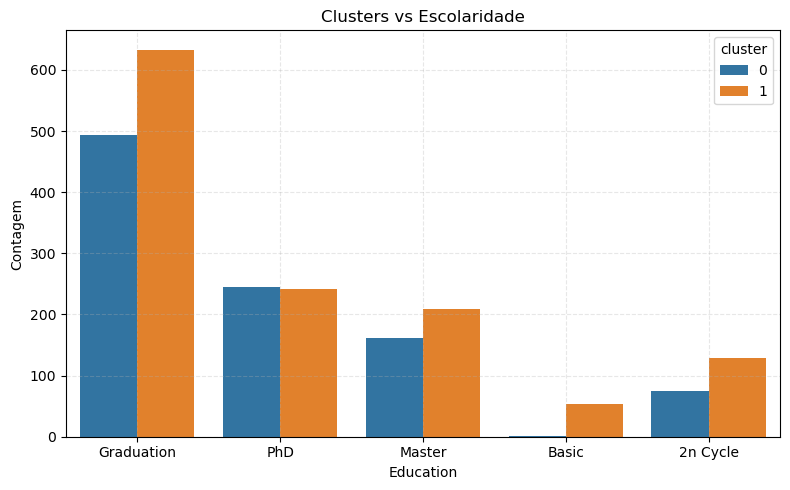

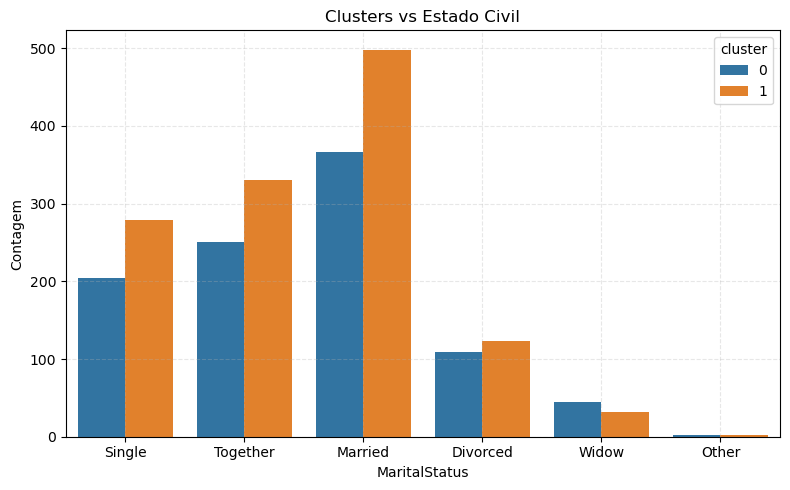

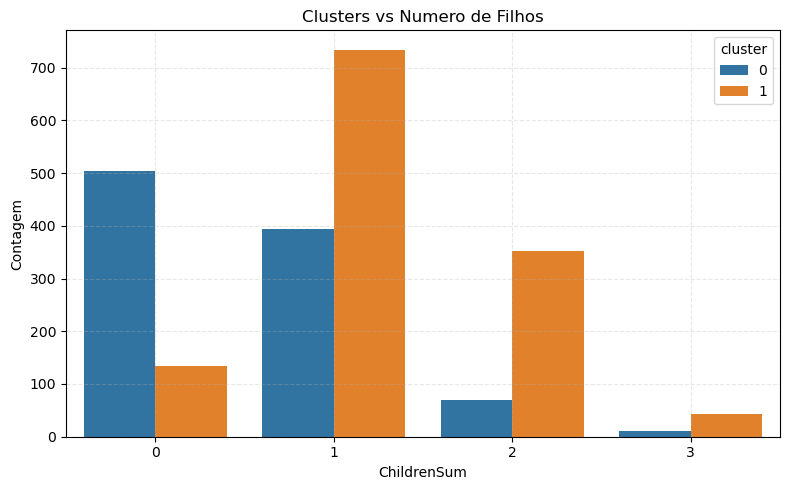

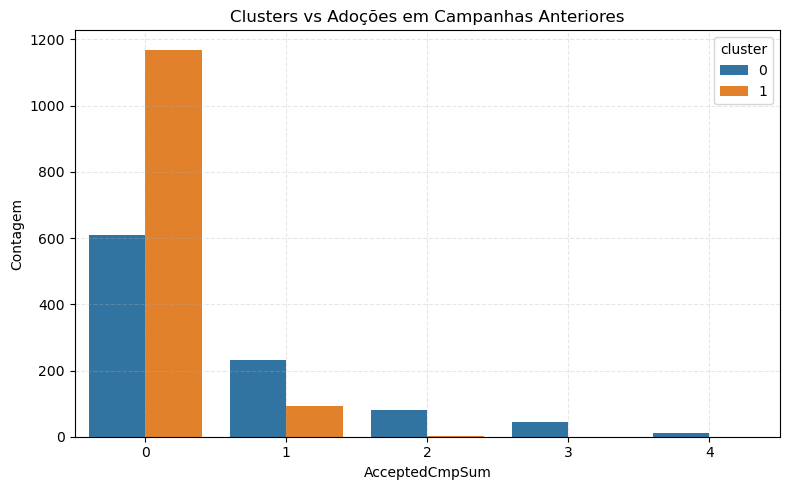

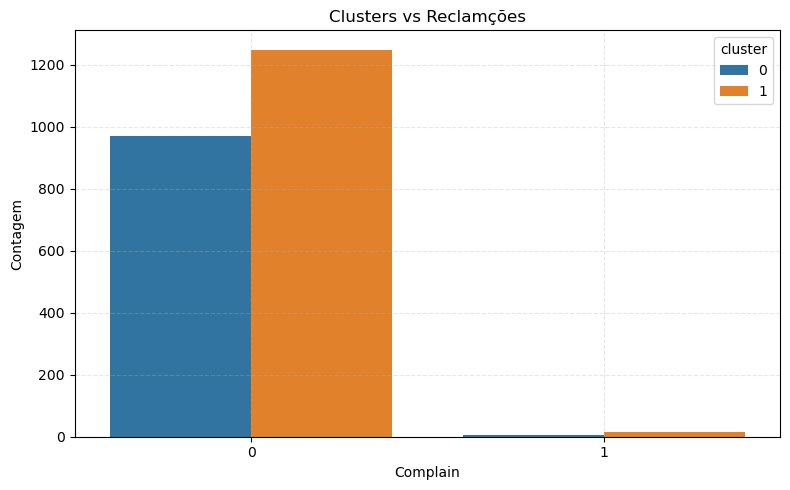

In [44]:
title_list = [
    'Clusters vs Escolaridade',
    'Clusters vs Estado Civil',
    'Clusters vs Numero de Filhos',
    'Clusters vs Adoções em Campanhas Anteriores',
    'Clusters vs Reclamções',
]

for i,title in zip(cluster_dados_categoricos,title_list):
    response_countplot(df_cluster, i, target='cluster',title=title)

### Variáveis Numéricas

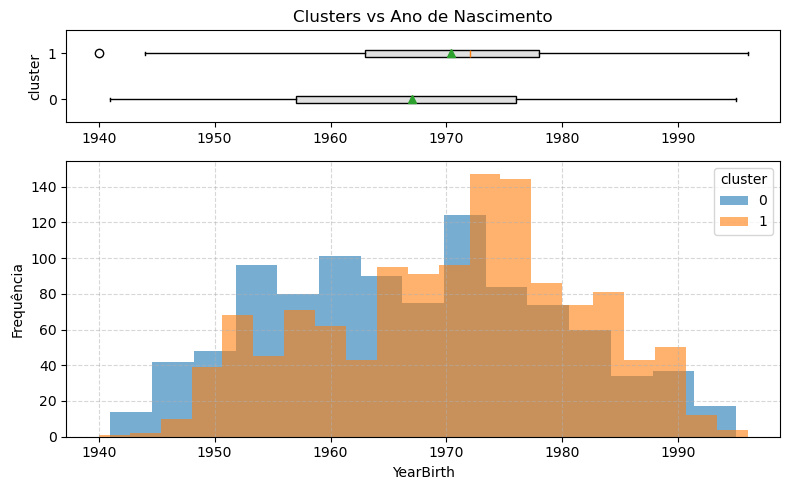

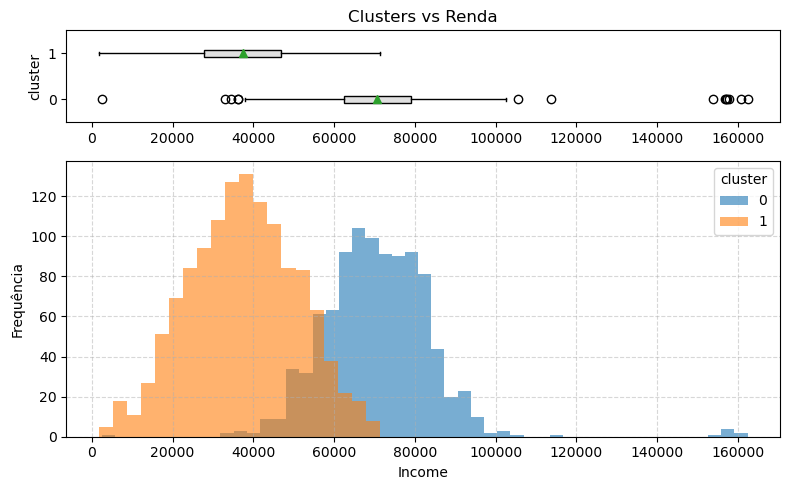

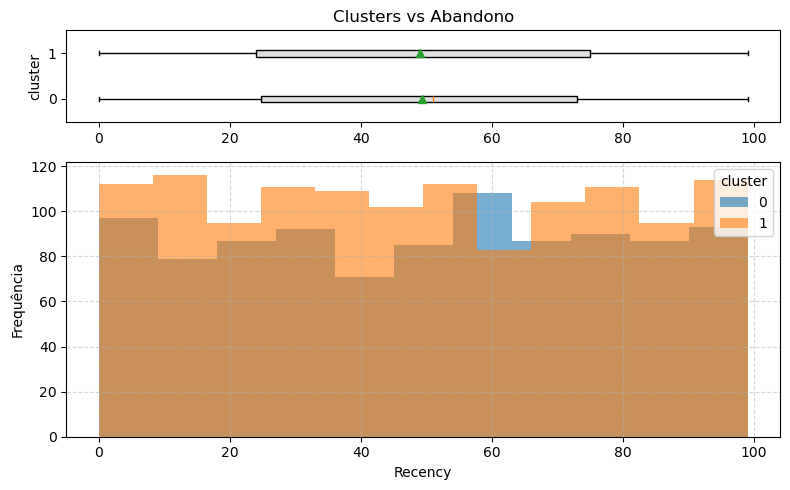

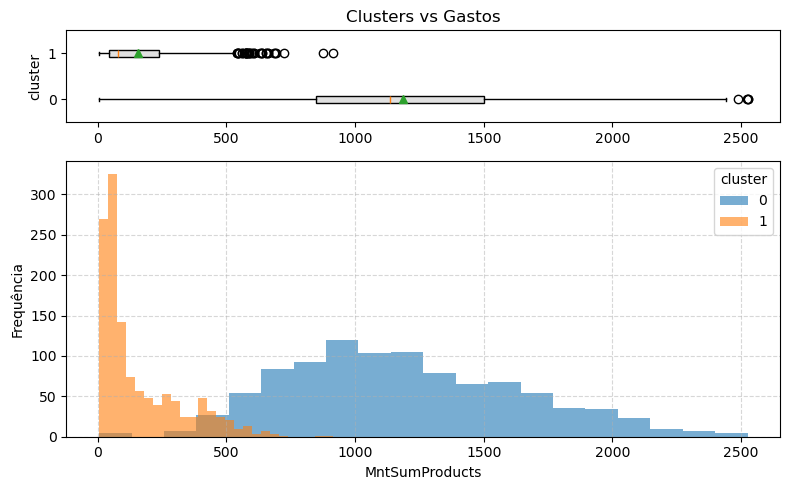

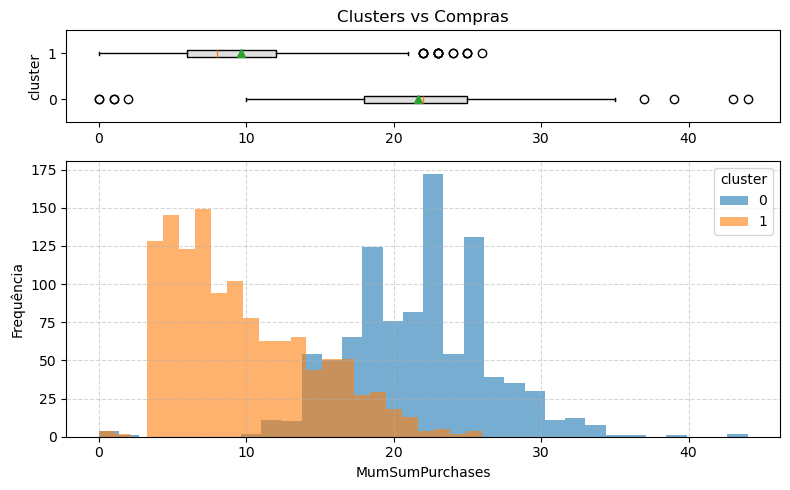

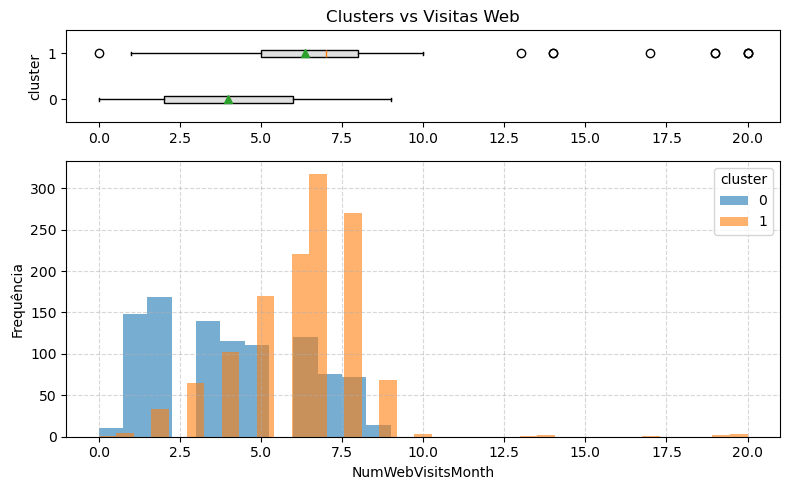

In [45]:
title_list = [
    'Clusters vs Ano de Nascimento',
    'Clusters vs Renda',
    'Clusters vs Abandono',
    'Clusters vs Gastos',
    'Clusters vs Compras',
    'Clusters vs Visitas Web',
]

for i,title in zip(cluster_dados_numericos,title_list):
    analisar_distribuicao_numerica(df_cluster, i, target='cluster',title=title)

# Modelo para a Próxima Campanha

Esta seção tem como objetivo identificar, com base nos dados da campanha piloto, os usuários que possuem maior potencial de retorno financeiro se forem contatados na próxima campanha.

Para isso, desenvolvemos um modelo preditivo utilizando regressão logística, com as mesmas variáveis utilizadas na segmentação (renda, recência, total gasto, número de compras, e variáveis demográficas e de engajamento).

Após o treinamento do modelo, identificamos que o *threshold* que maximiza o lucro é de 0,46. Ele nos dá um lucro de 187 com 66 contatos.

In [46]:
df_model = df.copy()

features = [
    'IsHighEducation','IsAlone','HaveChildren','IsAcceptedAny',
    'Income','Recency','MntSumProducts','MumSumPurchases'
]

X = df_model[features]
y = df_model['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=4)

In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

X_test_probs = logreg.predict_proba(X_test_scaled)[:, 1]

In [49]:
df_result = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
df_result['prob_response'] = X_test_probs
df_result['Response'] = y_test
df_result['ZCostContact'] = df_model.loc[df_result.index, 'ZCostContact']
df_result['ZRevenue'] = df_model.loc[df_result.index, 'ZRevenue']

thresholds = np.arange(0.0, 1.01, 0.01)
results = []

for t in thresholds:
    selected = df_result[df_result['prob_response'] >= t]
    cost = selected['ZCostContact'].sum()
    revenue = selected.loc[selected['Response'] == 1, 'ZRevenue'].sum()
    net_value = revenue - cost
    results.append((t, len(selected), cost, revenue, net_value))

df_eval = pd.DataFrame(results, columns=['threshold', 'contatos', 'custo', 'receita', 'lucro'])

In [50]:
df_balance = df_eval[df_eval['lucro'] > 0].copy()
df_balance = df_balance.sort_values(by='contatos', ascending=False)

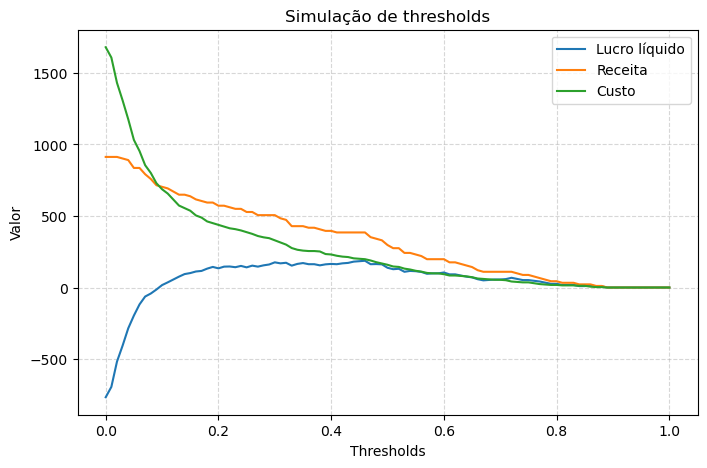

In [51]:
plt.figure(figsize=(8, 5))
plt.plot(df_eval['threshold'], df_eval['lucro'], label='Lucro líquido')
plt.plot(df_eval['threshold'], df_eval['receita'], label='Receita')
plt.plot(df_eval['threshold'], df_eval['custo'], label='Custo')
plt.xlabel('Thresholds')
plt.ylabel('Valor')
plt.title('Simulação de thresholds')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Conclusão

A partir dos modelos que construímos, temos dois caminhos possíveis:

1. **Segmentação:**

    Usar o perfil engajado da segmentação e criar uma campanha personalizada para esse grupo.  
    O problema é que, ao simular o reenvio da campanha piloto para esse público, o resultado seria um prejuízo de 519.

2. **Maior Lucro:**

    Usar o público filtrado pelo modelo de regressão logística (com *threshold* ≥ 0,46) e reenviar a campanha piloto.  
    Essa opção é mais segura, com lucro estimado de 187, mas com um público pequeno (66 pessoas).

In [52]:
cluster_engajado = df_cluster[df_cluster['cluster'] == 0]
c1_receita = cluster_engajado.loc[cluster_engajado['Response'] == 1, 'ZRevenue'].sum()
c1_custo = cluster_engajado['ZCostContact'].sum()
c1_lucro = c1_receita - c1_custo
c1_n = len(cluster_engajado)
c1_tx = round(cluster_engajado['Response'].sum() * 100 / c1_n, 2)

threshold_otimo = df_eval.sort_values(by='lucro', ascending=False).iloc[0]['threshold']
modelo_base = df_result[df_result['prob_response'] >= threshold_otimo]
c2_receita = modelo_base.loc[modelo_base['Response'] == 1, 'ZRevenue'].sum()
c2_custo = modelo_base['ZCostContact'].sum()
c2_lucro = c2_receita - c2_custo
c2_n = len(modelo_base)
c2_tx = round(modelo_base['Response'].sum() * 100 / c2_n, 2)

comparacao = pd.DataFrame({
    'Estratégia': [
        'Segmentação',
        'Maior Lucro',
    ],
    'Base usada': [
        'Cluster Engajado',
        f'Threshold ≥ {threshold_otimo:.2f}',
    ],
    'Nº de Contatos': [c1_n, c2_n],
    'Taxa de Adesão (%)': [c1_tx, c2_tx],
    'Receita (R$)': [round(c1_receita, 2), round(c2_receita, 2)],
    'Custo (R$)': [round(c1_custo, 2), round(c2_custo, 2)],
    'Lucro Líquido (R$)': [round(c1_lucro, 2), round(c2_lucro, 2)]
})

display(comparacao)


,Estratégia,Base usada,Nº de Contatos,Taxa de Adesão (%),Receita (R$),Custo (R$),Lucro Líquido (R$)
0,Segmentação,Cluster Engajado,976,22.44,2409,2928,-519
1,Maior Lucro,Threshold ≥ 0.46,66,53.03,385,198,187


## Proposta

Manter a campanha piloto, mas realizar um teste A/B para comparar a eficácia do modelo preditivo na seleção do público-alvo.

- **Controle:**

    Enviar a campanha para um grupo aleatório de usuários, como foi feito originalmente.

- **Modelo:**

    Enviar a campanha apenas para os usuários selecionados pelo modelo preditivo (*threshold* ≥ 0,46), que têm maior probabilidade de adesão.

Como métrica principal, utilizaremos o lucro obtido. Além disso, também acompanharemos a taxa de conversão, a receita gerada e o custo da campanha como métricas de apoio.

Fazer dessa forma é interessante, pois poderemos validar, com novos casos, se o modelo de fato entrega melhores resultados.

In [55]:
!jupyter nbconvert --to html --template pj apresentacao.ipynb

[NbConvertApp] Converting notebook apresentacao.ipynb to html
[NbConvertApp] Writing 7467064 bytes to apresentacao.html
